In [ ]:
import pandas as pd
df_data = pd.read_csv('reviews_clean_klasifikasi.csv')

In [ ]:
import re
from collections import OrderedDict
import numpy as np


class sentistrength:
    def __init__(self, config=dict()):
        self.negasi = [line.replace('\n','') for line in open("negatingword.txt").read().splitlines()]
        self.tanya = [line.replace('\n','') for line in open("questionword.txt").read().splitlines()]
        #create sentiment words dictionary
        self.sentiwords_txt = [line.replace('\n','').split(":") for line in open("sentiwords_id.txt").read().splitlines()]
        self.sentiwords_dict = OrderedDict()
        for term in self.sentiwords_txt:
            self.sentiwords_dict[term[0]] = int(term[1])
        #create emoticon dictionary
        self.emoticon_txt = [line.replace('\n','').split(" | ") for line in open("emoticon_id.txt").read().splitlines()]
        self.emoticon_dict = OrderedDict()
        for term in self.emoticon_txt:
            self.emoticon_dict[term[0]] = int(term[1])
        #create idioms dictionary
        self.idioms_txt = [line.replace('\n','').split(":") for line in open("idioms_id.txt").read().splitlines()]
        self.idioms_dict = OrderedDict()
        for term in self.idioms_txt:
            self.idioms_dict[term[0]] = int(term[1])
        #create boosterwords dictionary
        self.boosterwords_txt = [line.replace('\n','').split(":") for line in open("boosterwords_id.txt").read().splitlines()]
        self.boosterwords_dict = OrderedDict()
        for term in self.boosterwords_txt:
            self.boosterwords_dict[term[0]] = int(term[1])
        self.negation_conf = config["negation"]
        self.booster_conf = config["booster"]
        self.ungkapan_conf = config["ungkapan"]
        self.consecutive_conf = config["consecutive"]
        self.repeated_conf = config["repeated"]
        self.emoticon_conf = config["emoticon"]
        self.question_conf = config["question"]
        self.exclamation_conf = config["exclamation"]
        self.punctuation_conf = config["punctuation"]
        self.mean_conf = True

    def senti(self,term):
        try:
            return self.sentiwords_dict[term]
        except:
            return 0

    def emosikon(self,term):
        try:
            return self.emoticon_dict[term]
        except:
            return 0

    def ungkapan(self,term):
        try:
            return self.idioms_dict[term]
        except:
            return 0

    def booster(self, term):
        try:
            return self.boosterwords_dict[term]
        except:
            return 0

    def cek_negationword(self, prev_term, prev_term2):
        #jika kata sebelumnya (index-1) adalah kata negasi, negasikan nilai -+nya
        if prev_term in self.negasi or prev_term2+" "+prev_term in self.negasi:
            # print prev_term
            self.score = -abs(self.score) if self.score>0 else abs(self.score)

    def cek_boosterword(self,term):
        booster_score = self.booster(term)
        if booster_score !=0 and self.score>0: self.score += booster_score
        if booster_score !=0 and self.score<0: self.score -= booster_score

    def cek_consecutive_term(self, prev_term):
        if self.prev_score>0 and self.score >=3: self.score+=1 
        if self.prev_score<0 and self.score <=-3: self.score-=1 

    def cek_ungkapan(self, bigram,trigram, i):
        bigram = ' '.join(bigram)
        trigram = ' '.join(trigram)
        ungkapan_score = self.ungkapan(bigram)
        if ungkapan_score==0:
            ungkapan_score = self.ungkapan(trigram)
        if ungkapan_score!=0:
            self.score = ungkapan_score
            self.prev_score = 0
            self.pre_max_pos[i-1] = 1
            self.pre_max_neg[i-1] = -1
            self.max_pos = self.pre_max_pos[i-2] #if len(self.pre_max_pos)>1 else 1
            self.max_neg = self.pre_max_neg[i-2] #if len(self.pre_max_neg)>1 else -1
            self.sentence_score[i-1] = re.sub(r'\[\d\]','',self.sentence_score[i-1])

    def cek_repeated_punctuation(self, next_term):
        if re.search(r'!{2,}',next_term) and self.score >=3: self.score+=1
        if re.search(r'!{2,}',next_term) and self.score <=-3: self.score-=1

    def remove_extra_repeated_char(self, term):
        return re.sub(r'([A-Za-z])\1{2,}',r'\1',term)
    def plural_to_singular(self, term):
        return re.sub(r'([A-Za-z]+)\-\1', r'\1',term)
    def classify(self):
        result = "neutral"
        try:
            if self.mean_conf:
                self.mean_p = np.mean(self.mean_pos)
                self.mean_n = np.mean(self.mean_neg)
                if self.mean_p > self.mean_n:
                    result = "positive"
                elif self.mean_p < self.mean_n and not self.is_tanya:
                    result = "negative"
                elif self.mean_p < self.mean_n and self.is_tanya:
                    result = "neutral"
            else:
                if abs(self.sentences_max_pos) > abs(self.sentences_max_neg):
                    result = "positive"
                elif abs(self.sentences_max_pos) < abs(self.sentences_max_neg):
                    result = "negative"
                elif abs(self.sentences_max_pos) == abs(self.sentences_max_neg):
                    result = "neutral"
        except:
            print("error ",self.sentences_max_pos, self.sentences_max_neg)
        return result
    def cek_neutral_term(self,terms,i):
        if terms[i-1] in self.neutral_term or terms[i+1] in self.neutral_term: self.score=1 

    def main(self,sentence):
        self.neutral_term = ['jika','kalau']
        # sentence = re.sub('[%s]' % re.escape("!\"#$%&'()*+, -./:;<=>?@[\]^_`{|}~"), ' ', sentence)
        sentences = sentence.split('.')
        self.sentences_max_neg = -1
        self.sentences_max_pos = 1
        self.sentences_score = []
        self.sentences_text = []
        for sentence in sentences:
            self.max_neg = -1
            self.max_pos = 1
            self.mean_neg = [1]
            self.mean_pos = [1]
            self.sentence_score=[]
            terms = sentence.split()
            # terms = re.split(r'[\s,.]',sentence)
            terms_length = len(terms)
            self.is_tanya = False
            self.sentence_text = ''
            # print self.max_pos, self.max_neg
            #SEMUA KALIMAT YANG MEMILIKI TANDA SERU MEMILIKI +ve minimal 2
            if self.exclamation_conf and re.search('!',sentence): self.max_pos = 2
            self.prev_score = 0
            self.pre_max_pos = []
            self.pre_max_neg = []
            for i,term in enumerate(terms):
                # repeated_term = ''
                is_extra_char = False
                plural = ''
                self.score = 0
                # if re.search(r'[A-Za-z\-.]+',term):
                # print term
                if re.search(r'([A-Za-z])\1{3,}',term):
                    is_extra_char = True
                    # repeated_term =term
                term = self.remove_extra_repeated_char(term)
                if re.search(r'([A-Za-z]+)\-\1',term):
                    plural = term
                    term = self.plural_to_singular(term)
                #GET SENTI SCORE#
                self.score = self.senti(term)
                # print "senti score",term, self.score

                #NEGATION HANDLER#
                if self.negation_conf and self.score !=0 and i>0:self.cek_negationword(terms[i-1],terms[i-2])
                # print  "negation score",term, self.score

                #BOOSTERWORD HANDLER#
                if self.booster_conf and self.score !=0 and i>0 and i<=(terms_length-1):self.cek_boosterword(terms[i-1])
                if self.booster_conf and self.score !=0 and i>=0 and i<(terms_length-1):self.cek_boosterword(terms[i+1])
                # print  "booster score",term, self.score

                #IDIOM/UNGKAPAN HANDLER#
                if self.ungkapan_conf and i>0 and i<=(terms_length-1):self.cek_ungkapan([terms[i-1],term],[terms[i-2],terms[i-1],term],i)
                # if self.ungkapan_conf and i>=0 and i<(terms_length-1):self.cek_ungkapan([term,terms[i+1]])
                # print  "idiom score",term, self.score

                #CONSECUTIVE SENTIMENT WORD#
                if self.consecutive_conf and i>0 and i<=(terms_length-1) and self.score !=0:self.cek_consecutive_term(terms[i-1])
                # print  "consecutive score",term, self.score

                #+1 SENTI SCORE IF REPEATED CHAR ON POSITIVE/NEGATIVE +2 IF NEUTRAL TERM
                if self.repeated_conf and is_extra_char==True and self.score>0: self.score+=1
                if self.repeated_conf and is_extra_char==True and self.score<0: self.score-=1
                if self.repeated_conf and is_extra_char==True and self.score==0: self.score=2
                # print  "repeat char score", term, self.score
                if self.punctuation_conf and i>=0 and i<(terms_length-1): self.cek_repeated_punctuation(terms[i+1])
                # CEK APAKAH TERDAPAT KATA TANYA
                if self.question_conf and (term in self.tanya or re.search(r'\?',term)):self.is_tanya = True
                # CEK neutral term 
                if self.score!=0 and i>1 and i<(terms_length-2): self.cek_neutral_term(terms,i)
                # if self.score!=0 and i>0 and i<(terms_length-4): self.cek_neutral_term(terms,i)
                if self.emoticon_conf and self.score==0: self.score = self.emosikon(term)

                self.prev_score = self.score
                if self.mean_conf and self.score>0: self.mean_pos.append(self.score)	
                if self.mean_conf and self.score<0: self.mean_neg.append(abs(self.score))
                #GET MAX SCORE +ve/-ve	
                self.max_pos= self.score if self.score > self.max_pos else self.max_pos
                self.max_neg= self.score if self.score < self.max_neg else self.max_neg
                #insert score info current term
                self.pre_max_pos.append(self.max_pos)
                self.pre_max_neg.append(self.max_neg)
                # print self.pre_max_pos, self.pre_max_neg
                if plural !='': term = plural
                self.sentence_text += ' {}'.format(term)
                if self.score != 0:term = "{} [{}]".format(term, self.score)
                self.sentence_score.append(term)
            self.sentences_text.append(self.sentence_text)
            self.sentences_score.append(" ".join(self.sentence_score))
            if self.is_tanya: 
                self.max_neg = -1
            self.sentences_max_pos = self.max_pos if self.max_pos > self.sentences_max_pos else self.sentences_max_pos
            self.sentences_max_neg = self.max_neg if self.max_neg < self.sentences_max_neg else self.sentences_max_neg
            # print self.sentences_max_pos, self.sentences_max_neg
        sentence_result = self.classify()
        # print self.sentences_text
        return {"classified_text":". ".join(self.sentences_score),"tweet_text":". ".join(self.sentences_text),"sentence_score":self.sentences_score,"mean_positive":self.mean_p,"mean_negative":self.mean_n,"kelas":sentence_result}



In [ ]:
config = dict()
config["negation"] = True
config["booster"]  = True
config["ungkapan"]  = True
config["consecutive"]  = True
config["repeated"]  = True
config["emoticon"]  = True
config["question"]  = True
config["exclamation"]  = True
config["punctuation"]  = True
senti = sentistrength(config)
senti.main("Game ini gak ada event Ramadannya. . ?, Padahal kan game buatan Indonesia. Game yang lain walaupun bukan game indo ada kok event Ramadannya. ")

{'classified_text': 'Game ini gak ada event Ramadannya. . ?, Padahal kan game buatan [-2] Indonesia. Game yang lain walaupun bukan game indo ada kok [-2] event Ramadannya. ',
 'tweet_text': ' Game ini gak ada event Ramadannya. .  ?, Padahal kan game buatan Indonesia.  Game yang lain walaupun bukan game indo ada kok event Ramadannya. ',
 'sentence_score': ['Game ini gak ada event Ramadannya',
  '',
  '?, Padahal kan game buatan [-2] Indonesia',
  'Game yang lain walaupun bukan game indo ada kok [-2] event Ramadannya',
  ''],
 'mean_positive': 1.0,
 'mean_negative': 1.0,
 'kelas': 'neutral'}

In [ ]:
import numpy as np

label_data = []
temps = []
for index, row in df_data.iterrows():
  temp = senti.main((row["content"]))
  temps.append(temp)
  if(temp.get('kelas') == "neutral"):
    if(row['score']) > 3:
      label_data.append('positive')
      continue
    elif (row['score']) < 3:
      label_data.append('negative')
      continue
  label_data.append(temp.get('kelas'))

df_data['sentimen'] = label_data
df_data['temp'] = temps
df_data = df_data.drop(df_data[df_data['sentimen'] == 'neutral'].index)
df_data['sentimen'].replace("positive", 1, inplace=True)
df_data['sentimen'].replace("negative", -1, inplace=True)

In [ ]:
# !pip install matplotlib --upgrade

[Text(0, 0, '777'), Text(0, 0, '3282')]

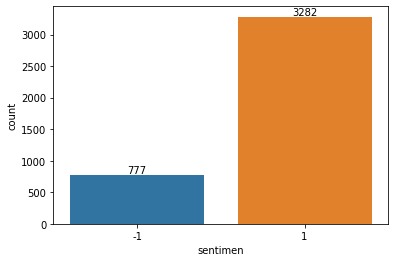

In [ ]:
import seaborn as sns
plot = sns.countplot(data=df_data, x='sentimen')
plot.bar_label(plot.containers[0])

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

def split_data(df, col_name, test_size):
    words = df.text_processed.tolist()
    label = df[col_name].tolist()
    x_train, x_test, y_train, y_test = train_test_split(words, label, test_size=test_size)
    return x_train, x_test, y_train, y_test

x_train_1, x_test_1, y_train_1, y_test_1 = split_data(df_data, 'sentimen', test_size= 0.2)

In [ ]:
#Dokumentasi hasil Splitting Data
def save_list_as_csv(list1, list2, save_dir):
    columns = {}

    columns['X'] = list1
    columns['y'] = list2

    data = list(zip(columns['X'],columns['y']))

    df = pd.DataFrame(data = data)

    df.to_csv(save_dir, index=False, header=['X', 'y'])

save_list_as_csv(x_train_1, y_train_1, 'Hasil Splitting Data/Data_latih.csv')
save_list_as_csv(x_test_1, y_test_1, 'Hasil Splitting Data/Data_test.csv')

In [1]:
# import pandas as pd
# df_data = pd.read_csv('Data_latih (1).csv')
# x_train_1 = df_data.X.tolist() 
# y_train_1 = df_data.y.tolist() 

# df_data = pd.read_csv('Data_test (1).csv')
# x_test_1 = df_data.X.tolist() 
# y_test_1 = df_data.y.tolist()

In [ ]:
import matplotlib.pyplot as plt

df = pd.DataFrame({'sentimen': y_train_1})
print(df.sentimen.value_counts())

 1    2627
-1     620
Name: sentimen, dtype: int64


In [ ]:
import matplotlib.pyplot as plt

df = pd.DataFrame({'sentimen': y_test_1})
print(df.sentimen.value_counts())

 1    655
-1    157
Name: sentimen, dtype: int64


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_vectorizer(x_train, x_test):
    vectorizer = TfidfVectorizer(sublinear_tf=True)
    vecx_train = vectorizer.fit_transform(x_train).toarray()
    vecx_test = vectorizer.transform(x_test).toarray()
    return vecx_train, vecx_test, vectorizer

In [4]:
vectorizer = TfidfVectorizer(sublinear_tf=True)
vectors = vectorizer.fit_transform(x_train_1)
vectors.shape[0]
tf_idf = pd.DataFrame(vectors.todense())
tf_idf.columns = vectorizer.get_feature_names_out()
tfidf_matrix = tf_idf.T
tfidf_matrix.columns = ['ulasan ' + str(i) for i in range(1, vectors.shape[0]+1)]
tfidf_matrix['count'] = tfidf_matrix.sum(axis=1)

# Top 10 words 
tfidf_matrix = tfidf_matrix.sort_values(by ='count', ascending=False)[:10] 

# Print the first 10 words 
print(tfidf_matrix.drop(columns=['count']).head(10))
print('\n\n')

           ulasan 1  ulasan 2  ulasan 3  ulasan 4  ulasan 5  ulasan 6  \
bagus           0.0  0.196506  0.000000  0.464096  0.000000  0.073077   
tidak           0.0  0.216467  0.082868  0.000000  0.060663  0.136300   
indonesia       0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
banget          0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
keren           0.0  0.000000  0.115453  0.000000  0.000000  0.000000   
atma            0.0  0.000000  0.000000  0.000000  0.000000  0.227635   
tolong          0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
ya              0.0  0.000000  0.116933  0.000000  0.000000  0.000000   
update          0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
seru            0.0  0.000000  0.000000  0.000000  0.000000  0.000000   

           ulasan 7  ulasan 8  ulasan 9  ulasan 10  ...  ulasan 3238  \
bagus      0.000000       0.0  0.000000   0.000000  ...     0.132746   
tidak      0.000000       0.0  0.000000   0.097334  

In [6]:
from collections import Counter
from imblearn.over_sampling import SMOTE

def apply_oversampling(X, y):
    print('Original dataset shape %s' % Counter(y))
    sm = SMOTE(random_state=100)
    X_res, y_res = sm.fit_resample(X, y)
    print('Resampled dataset shape %s' % Counter(y_res))
    return X_res, y_res

In [7]:
from sklearn import svm
from time import time

def train_data_svm(x_train, y_train, c , g, k):
    t0 = time()
    model = svm.SVC(C=c, gamma=g, kernel=k)
    model.fit(x_train, y_train)
    print(f"\nTraining time: {round(time()-t0, 3)}s")
    t0 = time()
    return model

In [ ]:
from sklearn.naive_bayes import GaussianNB

def train_data_nb(x_train, y_train):
    t0 = time()
    model = GaussianNB()
    model.fit(x_train, y_train)
    print(f"\nTraining time: {round(time()-t0, 3)}s")
    t0 = time()
    return model

In [8]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report

def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)

    precision = precision_score(y_val, y_pred)
    recall  = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)
    print('Confusion Matrix:')
    print(confusion_matrix(y_val, y_pred))
    print('Classification Report:')
    print(classification_report(y_val, y_pred))
    print('precision: ', precision)
    print('recall: ', recall)
    print('f1: ', f1)
    print('accuracy: ', accuracy)
    print('-------------------')
    return precision, recall, f1, accuracy


In [ ]:
from random import randrange
def cross_validation_split(x_train, y_train, folds):
    dataset_split_x, dataset_split_y = list(), list()
    dataset_copy_x, dataset_copy_y  = list(x_train), list(y_train)
    fold_size = int(len(x_train) / folds)
    for i in range(folds):
      fold_x, fold_y = list(), list()
      while len(fold_x) < fold_size:
        index = randrange(len(dataset_copy_x))
        fold_x.append(dataset_copy_x.pop(index))
        fold_y.append(dataset_copy_y.pop(index))
      dataset_split_x.append(fold_x)
      dataset_split_y.append(fold_y)
    return dataset_split_x, dataset_split_y

In [ ]:
from random import seed
seed(2)
result_x, result_y = cross_validation_split(x_train_1, y_train_1, 5)
print(type(result_x))
test = result_x[1]
result_x.remove(test)
test2 = [data for fold in result_x for data in fold]
print(len(test2))
print((test2))

<class 'list'>
2596
['tampilan gambar alur cerita seru', 'gameplay bagus story bagus art bagus stuck log jarang', 'moga keren ya mulusin', 'bagus banget tegang nyata tolong ya jngan tidak indonesia banget cerita indonesia banget buru coba', 'fitur beli coin pake diamond gitu min biar mudah coinya hehe', 'info code atma pakai mbps habis paket tolong perbaiki bintang', 'bagus story dapett keren bintang yah dijadiin seri komik bintang', 'segi alur cerita tarik battle lumbago kadang crash tolong perbaiki', 'developer agate bawa nama developer indonesia dunia terima kash', 'nyoba lumbago tarik saran moga event item ya tidak tuju top istilahnya pay win tengkyu', 'chapter susah xp atma pelit banget tidak imbang gameplay nyusahin player kapasitas atma dibatasin diupgrade kapasitas mahal pelit late bingung', 'developer ganti bahasa language tidak pencet ya tolong', 'terfavorit story line tarik bagus diperpanjang seru bgst kembang', 'min akun google saldo tidak ade pas laku bayar terhubung tidak

In [ ]:
import pickle
def save_model(model, f_name):
  pickle.dump(model, open("Dokumentasi/model_"+f_name + ".pickle", "wb"))

def save_vectorizer(vectorizer, f_name):
  pickle.dump(vectorizer, open("Dokumentasi/vectorizer_"+f_name+".pickle", "wb"))

def save_grid(grid, f_name):
  pickle.dump(grid, open("Dokumentasi/grid_"+f_name+".pickle", "wb"))


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

def grid_search_cv(X_train, y_train):

    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(sublinear_tf=True)),
        ('sampling', SMOTE(random_state=100)),
        ('clf', svm.SVC())
    ])


    param_grid = {'clf__C': [0.1, 1, 10, 100], 
                  'clf__gamma': [1, 0.1, 0.01, 0.001],
                  'clf__kernel': ['rbf', 'linear', 'poly']} 
  
    grid = GridSearchCV(pipeline, param_grid, scoring='f1', cv=5, verbose = 3)
  
    grid.fit(X_train, y_train)
    print(grid.best_params_)
    print(grid.best_estimator_)
    return grid

In [ ]:
grid = grid_search_cv(x_train_1, y_train_1)
save_grid(grid, "grid_svm")

In [ ]:
from statistics import mean

def kfold_cv(X_train, y_train, k, method, C, gamma, kernel):
  precision_avg = list()
  recall_avg = list()
  f1_avg = list()
  accuracy_avg= list()
  models = list()
  vectorizers = list()

  X_split, y_split = cross_validation_split(X_train, y_train, k)
  for i in range(k):
    x_copy, y_copy = list(X_split), list(y_split)
    X_val, y_val= x_copy[i], y_copy[i]
    x_copy.pop(i)
    y_copy.pop(i)
    X_train, y_train = [data for fold in x_copy for data in fold], [data for fold in y_copy for data in fold]
    X_train, X_val, vectorizer = tfidf_vectorizer(X_train, X_val)
    X_train, y_train = apply_oversampling(X_train, y_train)
    if method == 'svm':
      model = train_data_svm(X_train, y_train, C, gamma, kernel)
      print('model', i+1, 'created, X_val:', len(X_val), 'y_val', len(y_val))
      precision, recall, f1, accuracy = evaluate_model(model, X_val, y_val)
    else:
      model = train_data_nb(X_train, y_train)
      print('model', i+1, 'created, X_val:', len(X_val), 'y_val', len(y_val))
      precision, recall, f1, accuracy = evaluate_model(model, X_val, y_val)
  
    precision_avg.append(precision)
    recall_avg.append(recall)
    f1_avg.append(f1)
    accuracy_avg.append(accuracy)
    models.append(model)
    vectorizers.append(vectorizer)

  print("--------------------------")
  print("-------Avarage Score------")
  print("--------------------------")
  print("Precision_avg: ", mean(precision_avg))
  print("recall_avg: ", mean(recall_avg))
  print("f1_avg: ", mean(f1_avg))
  print("accuracy_avg: ", mean(accuracy_avg))

  return models, vectorizers


In [ ]:
models, vectorizers = kfold_cv(x_train_1, y_train_1, 5, 'svm', 1, 1, 'rbf')

for i in range(len(models)):
  save_model(models[i], "svm_"+str(i))
  save_vectorizer(vectorizers[i], "svm_"+str(i))

In [9]:
X_train, X_test, vectorizer = tfidf_vectorizer(x_train_1, x_test_1)

X_train, y_train_1 = apply_oversampling(X_train, y_train_1)
print(len(X_train), len(y_train_1))
model = train_data_svm(X_train, y_train_1, 10, 1, 'rbf')
precision, recall, f1, accuracy = evaluate_model(model, X_test, y_test_1)
# save_model(model, "svm_final")
# save_vectorizer(vectorizer, "svm_final")

Original dataset shape Counter({1: 2627, -1: 620})
Resampled dataset shape Counter({1: 2627, -1: 2627})
5254 5254

Training time: 61.894s
Confusion Matrix:
[[ 42 115]
 [ 21 634]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.67      0.27      0.38       157
           1       0.85      0.97      0.90       655

    accuracy                           0.83       812
   macro avg       0.76      0.62      0.64       812
weighted avg       0.81      0.83      0.80       812

precision:  0.8464619492656876
recall:  0.9679389312977099
f1:  0.9031339031339032
accuracy:  0.8325123152709359
-------------------


In [10]:
# X_train, X_test, vectorizer = tfidf_vectorizer(x_train_1, x_test_1)
y_pred = model.predict(X_test)
# precision, recall, f1, accuracy = evaluate_model(model, X_train, y_train_1)

In [11]:
df_data_topic = pd.read_csv('reviews_clean_klasf_topic.csv')

In [12]:
df_data['y_pred'] = y_pred
df3 = pd.merge(df_data, df_data_topic, left_on='X', right_on='text_processed')

#view result
print(df3)


                                                     X  y  y_pred  \
0    developer tolong sistem reser atma plis biar r...  1       1   
1                bagus tidak suka kek gini habis tagih  1       1   
2      keren memasukan kebudayan indonesia nyaman main  1       1   
3    sistem fight club error yaa pas challenge gaga... -1       1   
4    chapter episode min bintang heronya cuman ment... -1       1   
..                                                 ... ..     ...   
807  keren jalan cerita tarik indonesia banget ayo ...  1       1   
808  bagus segi story musik interface alam main pua...  1       1   
809  mnrt santai ringan cocok lepas penat saran tol...  1       1   
810   tidak menemukan balance campaing level atma kuat  1       1   
811     tolong rate bintang gedein dikit bintang susah  1      -1   

                                               content  score  \
0    Saya punya permintaan sama developer, tolong k...      5   
1    Bagus gamenya awalnya saya gak suka 

In [ ]:
df3.to_csv('reviews_clean_topic_sentiment_final_tfidf.csv', index=None, header=True)

In [13]:
import seaborn as sns
import numpy as np
import ast

aspect = df3["topic"].unique()

positive_list = []
negative_list = []

for i in aspect:
  positive = 0
  negative = 0
  for index, row in df3.iterrows():
    if i == row['topic']:
      if row['y'] == 1:
        positive = positive + 1
      if row['y'] == -1:
        negative = negative + 1
  positive_list.append(positive)
  negative_list.append(negative)

print(positive_list)
print(negative_list)

[417, 30, 39, 113, 56]
[63, 39, 10, 12, 33]


range(5, 2)


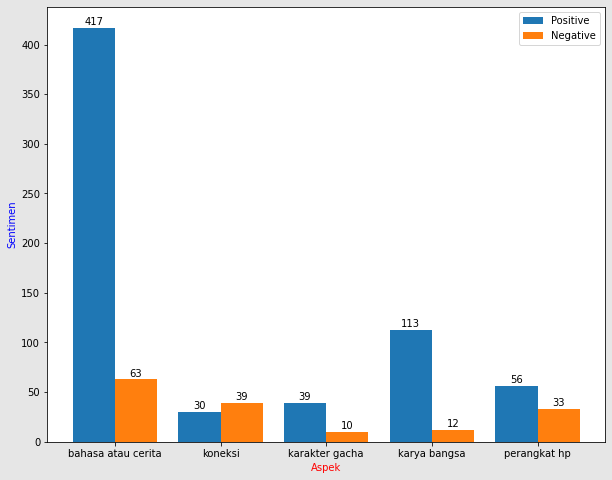

In [14]:
import matplotlib.pyplot as plt 

X_axis = np.arange(len(aspect))
  
plt.figure(figsize=(10, 8), facecolor='0.9')
test = plt.bar(X_axis - 0.2, positive_list, 0.4, label = 'Positive')
plt.bar(X_axis + 0.2, negative_list, 0.4, label = 'Negative')
print(range(len(positive_list), 2))
for i in range(0, len(positive_list), 1):
  plt.text(i - 0.2,positive_list[i] + 3,positive_list[i], ha = 'center')
  plt.text(i + 0.2,negative_list[i] + 3,negative_list[i], ha = 'center')

plt.xticks(X_axis, aspect)
plt.ylabel("Sentimen")
plt.xlabel("Aspek")
plt.gca().yaxis.label.set_color('blue') 
plt.gca().xaxis.label.set_color('red') 

# plt.title("Number of Students in each group")
from matplotlib.pyplot import figure

plt.legend()
plt.show()

------------------------------
aspect:  bahasa atau cerita


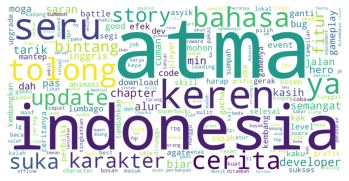

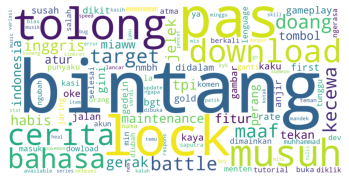

------------------------------
aspect:  koneksi


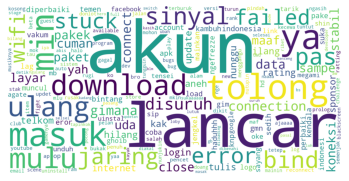

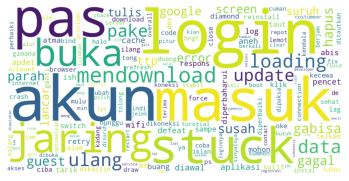

------------------------------
aspect:  karakter gacha


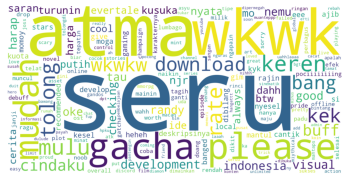

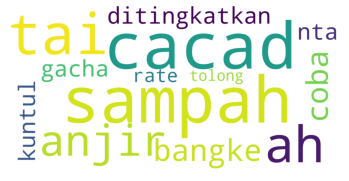

------------------------------
aspect:  karya bangsa


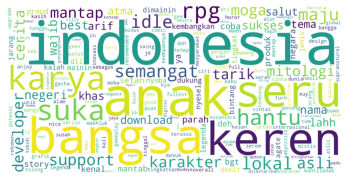

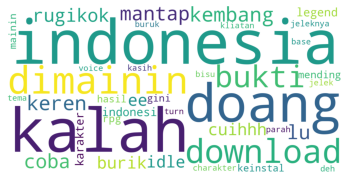

------------------------------
aspect:  perangkat hp


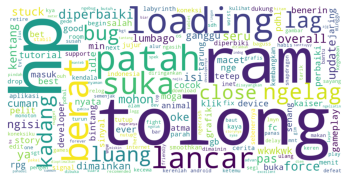

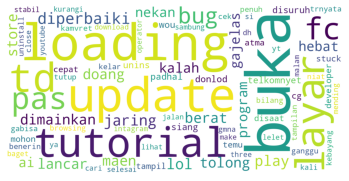

In [19]:
from wordcloud import WordCloud
stop_words = ['tidak', 'bagus', 'banget', 'main']

import matplotlib.pyplot as plt
from wordcloud import WordCloud

def join_data(X):
    joined_data = " ".join([data for data in X])
    return joined_data

def tfidf_vectorizer_2(X):
    vectorizer = TfidfVectorizer(sublinear_tf=True, stop_words=stop_words)
    vectorized_X = vectorizer.fit_transform(X)
    return vectorized_X, vectorizer

def create_wordcloud(df, label):
    df_pos = df[(df.topic == label) & (df.y_pred == 1)]
    X = join_data(df_pos.X)
    X, vectorizer = tfidf_vectorizer_2(df_pos.X)
    f_names = vectorizer.get_feature_names_out()
    dense = X.todense()
    denselist = dense.tolist()
    df_pos = pd.DataFrame(denselist, columns=f_names)
    data_pos = df_pos.T.sum(axis=1)

    df_neg = df[(df.topic == label) & (df.y_pred == -1)]
    X = join_data(df_neg.X)
    X, vectorizer = tfidf_vectorizer_2(df_neg.X)
    f_names = vectorizer.get_feature_names_out()
    dense = X.todense()
    denselist = dense.tolist()
    df_neg = pd.DataFrame(denselist, columns=f_names)
    data_neg = df_neg.T.sum(axis=1)
    return data_pos, data_neg

def get_wordcloud(df):
  for aspect in df3["topic"].unique():
    print("------------------------------")
    print('aspect: ', aspect)
    data_pos, data_neg = create_wordcloud(df, aspect)
    wordcloud = WordCloud(background_color="white",width=1600,height=800, stopwords=stop_words, random_state=50).generate_from_frequencies(data_pos)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    print("\n")
    wordcloud = WordCloud(background_color="white",width=1600,height=800, stopwords=stop_words, random_state=50).generate_from_frequencies(data_neg)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

get_wordcloud(df3)

In [ ]:
models, vectorizers = kfold_cv(x_train_1, y_train_1, 5, 'nb', 10, 1, 'rbf')
for i in range(len(models)):
  save_model(models[i], "nb_"+str(i))
  save_vectorizer(vectorizers[i], "nb_"+str(i))

Original dataset shape Counter({1: 2105, -1: 491})
Resampled dataset shape Counter({1: 2105, -1: 2105})

Training time: 0.329s
model 1 created, X_val: 649 y_val 649
Confusion Matrix:
[[ 56  73]
 [181 339]]
precision:  0.8228155339805825
recall:  0.6519230769230769
f1:  0.7274678111587982
accuracy:  0.6086286594761171
-------------------
Original dataset shape Counter({1: 2097, -1: 499})
Resampled dataset shape Counter({1: 2097, -1: 2097})

Training time: 0.31s
model 2 created, X_val: 649 y_val 649
Confusion Matrix:
[[ 59  62]
 [183 345]]
precision:  0.8476658476658476
recall:  0.6534090909090909
f1:  0.7379679144385026
accuracy:  0.6224961479198767
-------------------
Original dataset shape Counter({1: 2115, -1: 481})
Resampled dataset shape Counter({1: 2115, -1: 2115})

Training time: 0.468s
model 3 created, X_val: 649 y_val 649
Confusion Matrix:
[[ 71  68]
 [209 301]]
precision:  0.8157181571815718
recall:  0.5901960784313726
f1:  0.6848691695108078
accuracy:  0.5731895223420647
----

In [ ]:
# Precision_avg:  0.8363469602632179
# recall_avg:  0.966671393291273
# f1_avg:  0.8965570936042911
# accuracy_avg:  0.8219791129040752

In [ ]:
!zip -r Dokumentasi.zip Dokumentasi/

  adding: Dokumentasi/ (stored 0%)
  adding: Dokumentasi/model_svm_4.pickle (deflated 100%)
  adding: Dokumentasi/vectorizer_svm_0.pickle (deflated 65%)
  adding: Dokumentasi/grid_grid_svm.pickle (deflated 37%)
  adding: Dokumentasi/vectorizer_svm_3.pickle (deflated 65%)
  adding: Dokumentasi/vectorizer_svm_2.pickle (deflated 65%)
  adding: Dokumentasi/model_nb_3.pickle (deflated 47%)
  adding: Dokumentasi/vectorizer_nb_4.pickle (deflated 65%)
  adding: Dokumentasi/model_svm_3.pickle (deflated 100%)
  adding: Dokumentasi/model_svm_final.pickle (deflated 100%)
  adding: Dokumentasi/vectorizer_nb_1.pickle (deflated 65%)
  adding: Dokumentasi/vectorizer_svm_final.pickle (deflated 64%)
  adding: Dokumentasi/model_nb_4.pickle (deflated 47%)
  adding: Dokumentasi/vectorizer_nb_0.pickle (deflated 65%)
  adding: Dokumentasi/model_svm_1.pickle (deflated 100%)
  adding: Dokumentasi/model_nb_2.pickle (deflated 48%)
  adding: Dokumentasi/vectorizer_nb_2.pickle (deflated 65%)
  adding: Dokumentasi/

In [ ]:
from google.colab import files
files.download("Dokumentasi.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download("Hasil Splitting Data/Data_test.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>